In [1]:
# I was getting a ModuleNotFoundError, and I discovered that the cwd (current working directory) was
#   '<Github Home>/market-modeling/examples/' but it needs to be '<Github Home>/market-modeling/'
# The following code will add the cwd's parent directory to the path Python uses to search for packages
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import os
from datetime import datetime

from models.gbm_models.Models import DependentCovariateModel
from markets.Markets import XarrayMarket
from assets.Assets import HeirarchicalAsset
from metrics.Metrics import VarType, TimeseriesMetric, StaticMetric
from modeling_utils.py_utils import last_index_lt_1D

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, Normalize

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [3]:
DEBUG = True
DATA_DIR = '../data'
MARKET_NAME = 'popular_stocks'
TS_DIR = 'growth_timeseries'

In [5]:
asset_list = []
asset_metadata = pd.read_csv(os.path.join(DATA_DIR, MARKET_NAME, 'asset_metadata.tsv'), sep='\t')

for i, row in asset_metadata.iterrows():
  if DEBUG:
    if i == 5:
      break
  
  asset_ts = pd.read_csv(
    os.path.join(DATA_DIR, MARKET_NAME, TS_DIR, f"{row['id']}.csv"),
    parse_dates=['date'],
    dtype={'price' : np.float32}
  )
  
  asset = HeirarchicalAsset(
    row['name'],
    row['id'],
    {
      'signal': TimeseriesMetric(asset_ts['date'], asset_ts['price'], VarType.QUANTITATIVE),
	  'sector_id': StaticMetric(row['sector'], VarType.CATEGORICAL),
	  'industry_id': StaticMetric(row['industry'], VarType.CATEGORICAL)
    }
  )
  asset_list.append(asset)

market = XarrayMarket(asset_list, MARKET_NAME)
dep_cov_model = DependentCovariateModel(market)
market.align_timeseries()

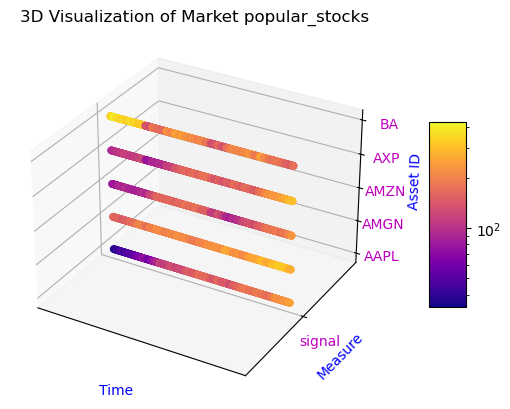

In [6]:
market.display_market()

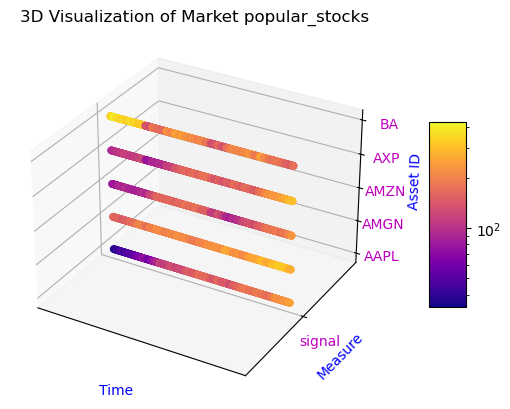

In [7]:
market.encode_indicators(True, ',')
market.display_market(show_indicators=False)

C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\krish\AppData\Roaming\Python\Python312\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


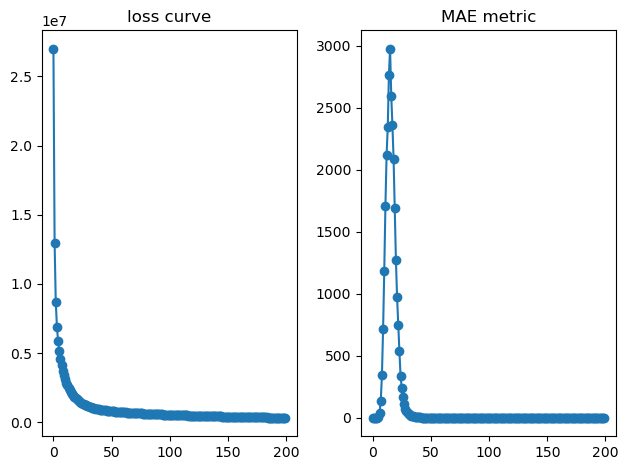

In [8]:
dep_cov_model.estimate_parameters()

In [9]:
dep_cov_model.drifts

array([-5.32358571e-05,  3.52573477e-03,  4.83409711e-03,  3.61394108e-03,
        1.47648937e-03])

In [10]:
dep_cov_model.summarize_covariate_distributions()

sector_id_financial-services		-0.0011
sector_id_technology		0.0006
sector_id_healthcare		-0.0123
sector_id_industrials		0.0212
sector_id_consumer-cyclical		-0.0009
industry_id_credit-services		-0.0009
industry_id_internet-retail		-0.0027
industry_id_drug-manufacturers-general		0.0097
industry_id_aerospace-defense		-0.0214
industry_id_consumer-electronics		0.0012


<Figure size 640x480 with 0 Axes>

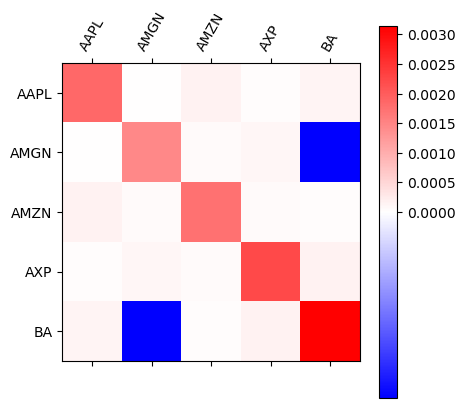

In [11]:
Sigma = dep_cov_model.get_correlation_mat()

if Sigma.min() < 0.:
  plt.set_cmap('bwr')
  cust_cmap = TwoSlopeNorm(0, Sigma.min(), Sigma.max())
else:
  plt.set_cmap('Reds')
  cust_cmap = Normalize(Sigma.min(), Sigma.max())
plt.matshow(Sigma, norm=cust_cmap)
plt.xticks(np.arange(Sigma.shape[0]), labels=[asset.asset_id for asset in market.assets], rotation=60)
plt.yticks(np.arange(Sigma.shape[1]), labels=[asset.asset_id for asset in market.assets])
plt.colorbar();

In [12]:
dates_to_sim = pd.to_datetime(
  pd.Series(['01-24-2025', '01-27-2025', '01-28-2025', '01-29-2025'], name='dates'),
  format='%m-%d-%Y'
)

prev_times, prev_state = market.get_market_state_before_date(min(dates_to_sim))
assert len(set(prev_times)) == 1, "market's times misaligned"
prev_signals = prev_state.sel(variable='signal').to_numpy()

sim_dates = pd.concat((pd.Series(prev_times[0:1], name='dates'), dates_to_sim))

In [13]:
sim_res = dep_cov_model.simulate(prev_signals, sim_dates, num_sims=20)
sim_counterfact = dep_cov_model.simulate(prev_signals, sim_dates, 1, add_BM=False)

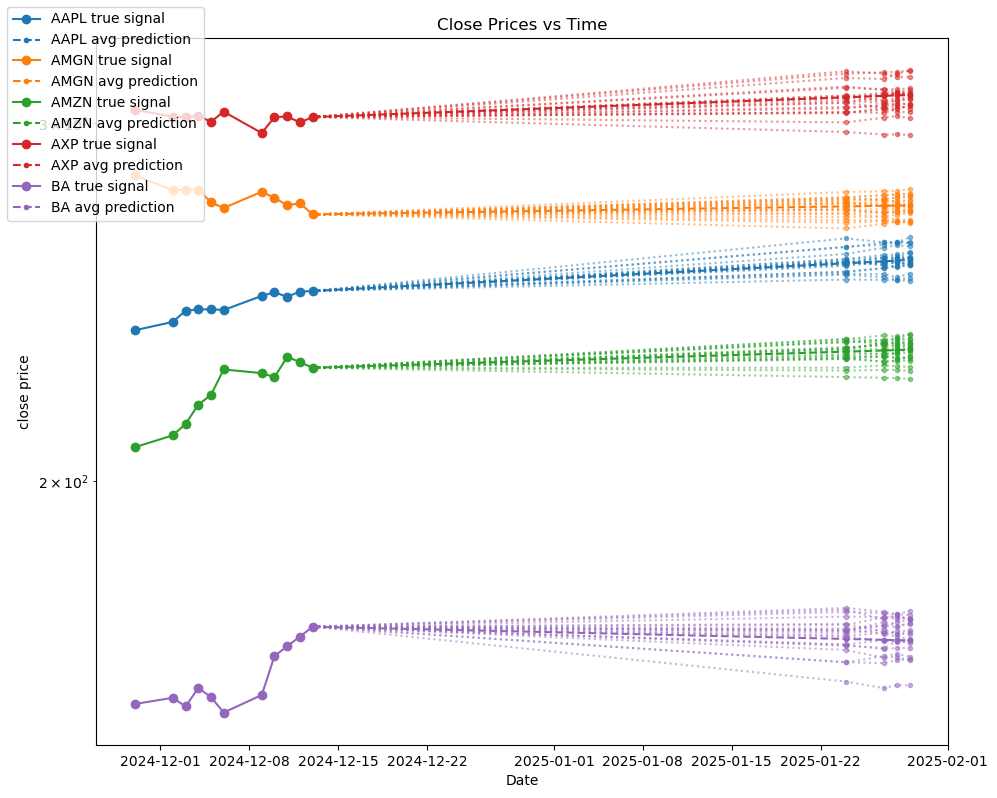

In [14]:
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
fig, ax = plt.subplots(figsize=(10,8))

xarr = market.get_dataarray()

PLOT_START_DT = np.datetime64(datetime(2024, 12, 1))
PLOT_START_IDX = last_index_lt_1D(xarr.time.values, PLOT_START_DT)

for i in range(len(colors)): #range(dep_model.N_ASSETS):
  asset_i = dep_cov_model.market.assets[i % dep_cov_model.N_ASSETS]
  disp_name = asset_i.asset_id

  init_data = xarr.isel(time=slice(PLOT_START_IDX, None))
  ax.plot(
    init_data.time, init_data.sel(ID=asset_i.asset_id, variable='signal'),
    '-o', color=colors[i % dep_cov_model.N_ASSETS],
    label=f'{disp_name} true signal'
  )

  ax.plot(
    sim_dates, sim_counterfact[0, i, :],
    color=colors[i % dep_cov_model.N_ASSETS], marker='.', linestyle='dashed',
    label=f'{disp_name} avg prediction'
  )
  for j_sim in range(sim_res.shape[0]):
    ax.plot(
      sim_dates, sim_res[j_sim, i, :],
      alpha=0.5, color=colors[i % dep_cov_model.N_ASSETS], linestyle='dotted', marker='.'
    )
ax.set(xlabel='Date', ylabel='close price', title='Close Prices vs Time')
ax.set_yscale('log')
fig.tight_layout()
fig.legend(loc=2);